In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
# import numpy & pytorch
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [3]:
torch.__version__

'0.4.0'

Reimplementation of

# Multi-style Generative Network for Real-time Transfer

original files created by [Hang Zhang](http://hangzh.com/), [Kristin Dana](http://eceweb1.rutgers.edu/vision/dana.html)

## Introduction
This is PyTorch example of real-time multi-style transfer. In this work, we introduce a Multi-style Generative Network (MSG-Net) with a novel Inspiration Layer, which retains the functionality of optimization-based approaches and has the fast speed of feed-forward networks. [[arXiv](https://arxiv.org/pdf/1703.06953.pdf)][[project](http://computervisionrutgers.github.io/MSG-Net/)]
```
@article{zhang2017multistyle,
	title={Multi-style Generative Network for Real-time Transfer},
	author={Zhang, Hang and Dana, Kristin},
	journal={arXiv preprint arXiv:1703.06953},
	year={2017}
}
```


## Tutorial
### Real-time Style Transfer using Pre-trained MSG-Net
- Define the model

In [4]:
# define Gram Matrix
class GramMatrix(nn.Module):
    def forward(self, y):
        (b, ch, h, w) = y.size()
        features = y.view(b, ch, w * h)
        features_t = features.transpose(1, 2)
        gram = features.bmm(features_t) / (ch * h * w)
        return gram

# proposed Inspiration(CoMatch) Layer
class Inspiration(nn.Module):
    """ Inspiration Layer (from MSG-Net paper)
    tuning the featuremap with target Gram Matrix
    ref https://arxiv.org/abs/1703.06953
    """
    def __init__(self, C, B=1):
        super(Inspiration, self).__init__()
        # B is equal to 1 or input mini_batch
        self.weight = nn.Parameter(torch.Tensor(1,C,C), requires_grad=True)
        # non-parameter buffer
        self.G = Variable(torch.Tensor(B,C,C), requires_grad=True)
        self.C = C
        self.reset_parameters()

    def reset_parameters(self):
        self.weight.data.uniform_(0.0, 0.02)

    def setTarget(self, target):
        self.G = target

    def forward(self, X):
        # input X is a 3D feature map
        self.P = torch.bmm(self.weight.expand_as(self.G),self.G)
        return torch.bmm(self.P.transpose(1,2).expand(X.size(0), self.C, self.C), X.view(X.size(0),X.size(1),-1)).view_as(X)

    def __repr__(self):
        return self.__class__.__name__ + '(' \
            + 'N x ' + str(self.C) + ')'
# some basic layers, with reflectance padding
class ConvLayer(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        super(ConvLayer, self).__init__()
        reflection_padding = int(np.floor(kernel_size / 2))
        self.reflection_pad = nn.ReflectionPad2d(reflection_padding)
        self.conv2d = nn.Conv2d(in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        out = self.reflection_pad(x)
        out = self.conv2d(out)
        return out

class UpsampleConvLayer(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, upsample=None):
        super(UpsampleConvLayer, self).__init__()
        self.upsample = upsample
        if upsample:
            self.upsample_layer = torch.nn.Upsample(scale_factor=upsample)
        self.reflection_padding = int(np.floor(kernel_size / 2))
        if self.reflection_padding != 0:
            self.reflection_pad = nn.ReflectionPad2d(self.reflection_padding)
        self.conv2d = nn.Conv2d(in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        if self.upsample:
            x = self.upsample_layer(x)
        if self.reflection_padding != 0:
            x = self.reflection_pad(x)
        out = self.conv2d(x)
        return out

class Bottleneck(nn.Module):
    """ Pre-activation residual block
    Identity Mapping in Deep Residual Networks
    ref https://arxiv.org/abs/1603.05027
    """
    def __init__(self, inplanes, planes, stride=1, downsample=None, norm_layer=nn.BatchNorm2d):
        super(Bottleneck, self).__init__()
        self.expansion = 4
        self.downsample = downsample
        if self.downsample is not None:
            self.residual_layer = nn.Conv2d(inplanes, planes * self.expansion,
                                                        kernel_size=1, stride=stride)
        conv_block = []
        conv_block += [norm_layer(inplanes),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, planes, kernel_size=1, stride=1)]
        conv_block += [norm_layer(planes),
                                    nn.ReLU(inplace=True),
                                    ConvLayer(planes, planes, kernel_size=3, stride=stride)]
        conv_block += [norm_layer(planes),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(planes, planes * self.expansion, kernel_size=1, stride=1)]
        self.conv_block = nn.Sequential(*conv_block)
        
    def forward(self, x):
        if self.downsample is not None:
            residual = self.residual_layer(x)
        else:
            residual = x
        return residual + self.conv_block(x)
    
class UpBottleneck(nn.Module):
    """ Up-sample residual block (from MSG-Net paper)
    Enables passing identity all the way through the generator
    ref https://arxiv.org/abs/1703.06953
    """
    def __init__(self, inplanes, planes, stride=2, norm_layer=nn.BatchNorm2d):
        super(UpBottleneck, self).__init__()
        self.expansion = 4
        self.residual_layer = UpsampleConvLayer(inplanes, planes * self.expansion,
                                                      kernel_size=1, stride=1, upsample=stride)
        conv_block = []
        conv_block += [norm_layer(inplanes),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, planes, kernel_size=1, stride=1)]
        conv_block += [norm_layer(planes),
                                    nn.ReLU(inplace=True),
                                    UpsampleConvLayer(planes, planes, kernel_size=3, stride=1, upsample=stride)]
        conv_block += [norm_layer(planes),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(planes, planes * self.expansion, kernel_size=1, stride=1)]
        self.conv_block = nn.Sequential(*conv_block)

    def forward(self, x):
        return  self.residual_layer(x) + self.conv_block(x)
# the MSG-Net
class Net(nn.Module):
    def __init__(self, input_nc=3, output_nc=3, ngf=64, norm_layer=nn.InstanceNorm2d, n_blocks=6, gpu_ids=[]):
        super(Net, self).__init__()
        self.gpu_ids = gpu_ids
        self.gram = GramMatrix()

        block = Bottleneck
        upblock = UpBottleneck
        expansion = 4

        model1 = []
        model1 += [ConvLayer(input_nc, 64, kernel_size=7, stride=1),
                            norm_layer(64),
                            nn.ReLU(inplace=True),
                            block(64, 32, 2, 1, norm_layer),
                            block(32*expansion, ngf, 2, 1, norm_layer)]
        self.model1 = nn.Sequential(*model1)

        model = []
        self.ins = Inspiration(ngf*expansion)
        model += [self.model1]
        model += [self.ins]    

        for i in range(n_blocks):
            model += [block(ngf*expansion, ngf, 1, None, norm_layer)]
        
        model += [upblock(ngf*expansion, 32, 2, norm_layer),
                            upblock(32*expansion, 16, 2, norm_layer),
                            norm_layer(16*expansion),
                            nn.ReLU(inplace=True),
                            ConvLayer(16*expansion, output_nc, kernel_size=7, stride=1)]

        self.model = nn.Sequential(*model)

    def setTarget(self, Xs):
        F = self.model1(Xs)
        G = self.gram(F)
        self.ins.setTarget(G)

    def forward(self, input):
        return self.model(input)


- Implement utils functions for read/write image

In [5]:
import os
from PIL import Image

# 读入照片，并存为torch.Tensor
def tensor_load_rgbimage(filename, size=None, scale=None, keep_asp=False):
    img = Image.open(filename).convert('RGB')
    if size is not None:
        if keep_asp:
            size2 = int(size * 1.0 / img.size[0] * img.size[1])
            img = img.resize((size, size2), Image.ANTIALIAS)
        else:
            img = img.resize((size, size), Image.ANTIALIAS)

    elif scale is not None:
        img = img.resize((int(img.size[0] / scale), int(img.size[1] / scale)), Image.ANTIALIAS)
    img = np.array(img).transpose(2, 0, 1)
    img = torch.from_numpy(img).float()
    return img

# 读入torch.Tensor，并存为照片文件
def tensor_save_rgbimage(tensor, filename, cuda=False):
    if cuda:
        img = tensor.clone().cpu().clamp(0, 255).numpy()
    else:
        img = tensor.clone().clamp(0, 255).numpy()
    img = img.transpose(1, 2, 0).astype('uint8')
    img = Image.fromarray(img)
    img.save(filename)


def tensor_save_bgrimage(tensor, filename, cuda=False):
    (b, g, r) = torch.chunk(tensor, 3)
    tensor = torch.cat((r, g, b))
    tensor_save_rgbimage(tensor, filename, cuda)
    
def preprocess_batch(batch):
    batch = batch.transpose(0, 1)
    (r, g, b) = torch.chunk(batch, 3)
    batch = torch.cat((b, g, r))
    batch = batch.transpose(0, 1)
    return batch

- Download the images and the model file

In [6]:
os.system('wget -O 21styles.model https://www.dropbox.com/s/2iz8orqqubrfrpo/21styles.model?dl=1')

1

- Person image

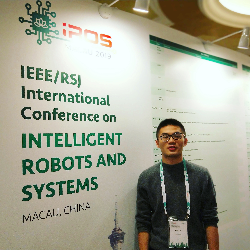

In [12]:
display(Image.open('./experiments/images/Yujie_He-IROS.jpg').resize((250, 250)))

- Demo image

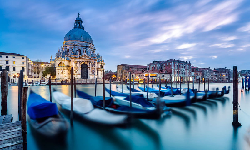

In [13]:
display(Image.open('./experiments/images/content/venice-boat.jpg').resize((250, 150)))

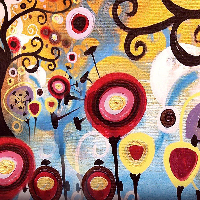

In [14]:
display(Image.open('./experiments/images/9styles/candy.jpg').resize((200, 200)))

- Load the images and preprocessing

In [15]:
personal_image = tensor_load_rgbimage('./experiments/images/Yujie_He-IROS.jpg', size=512, keep_asp=True).unsqueeze(0)
demo_image = tensor_load_rgbimage('./experiments/images/content/venice-boat.jpg', size=512, keep_asp=True).unsqueeze(0)
style = tensor_load_rgbimage('./experiments/images/9styles/candy.jpg', size=512).unsqueeze(0)    
style = preprocess_batch(style)

- Create MSG-Net and load pre-trained weights

In [16]:
style_model = Net(ngf=128)
style_model.load_state_dict(torch.load('./experiments/models/21styles.model'), False)

RuntimeError: Error(s) in loading state_dict for Net:
	Unexpected running stats buffer(s) "model1.1.running_mean" and "model1.1.running_var" for InstanceNorm2d with track_running_stats=False. If state_dict is a checkpoint saved before 0.4.0, this may be expected because InstanceNorm2d does not track running stats by default since 0.4.0. Please remove these keys from state_dict. If the running stats are actually needed, instead set track_running_stats=True in InstanceNorm2d to enable them. See the documentation of InstanceNorm2d for details.
	Unexpected running stats buffer(s) "model1.3.conv_block.0.running_mean" and "model1.3.conv_block.0.running_var" for InstanceNorm2d with track_running_stats=False. If state_dict is a checkpoint saved before 0.4.0, this may be expected because InstanceNorm2d does not track running stats by default since 0.4.0. Please remove these keys from state_dict. If the running stats are actually needed, instead set track_running_stats=True in InstanceNorm2d to enable them. See the documentation of InstanceNorm2d for details.
	Unexpected running stats buffer(s) "model1.3.conv_block.3.running_mean" and "model1.3.conv_block.3.running_var" for InstanceNorm2d with track_running_stats=False. If state_dict is a checkpoint saved before 0.4.0, this may be expected because InstanceNorm2d does not track running stats by default since 0.4.0. Please remove these keys from state_dict. If the running stats are actually needed, instead set track_running_stats=True in InstanceNorm2d to enable them. See the documentation of InstanceNorm2d for details.
	Unexpected running stats buffer(s) "model1.3.conv_block.6.running_mean" and "model1.3.conv_block.6.running_var" for InstanceNorm2d with track_running_stats=False. If state_dict is a checkpoint saved before 0.4.0, this may be expected because InstanceNorm2d does not track running stats by default since 0.4.0. Please remove these keys from state_dict. If the running stats are actually needed, instead set track_running_stats=True in InstanceNorm2d to enable them. See the documentation of InstanceNorm2d for details.
	Unexpected running stats buffer(s) "model1.4.conv_block.0.running_mean" and "model1.4.conv_block.0.running_var" for InstanceNorm2d with track_running_stats=False. If state_dict is a checkpoint saved before 0.4.0, this may be expected because InstanceNorm2d does not track running stats by default since 0.4.0. Please remove these keys from state_dict. If the running stats are actually needed, instead set track_running_stats=True in InstanceNorm2d to enable them. See the documentation of InstanceNorm2d for details.
	Unexpected running stats buffer(s) "model1.4.conv_block.3.running_mean" and "model1.4.conv_block.3.running_var" for InstanceNorm2d with track_running_stats=False. If state_dict is a checkpoint saved before 0.4.0, this may be expected because InstanceNorm2d does not track running stats by default since 0.4.0. Please remove these keys from state_dict. If the running stats are actually needed, instead set track_running_stats=True in InstanceNorm2d to enable them. See the documentation of InstanceNorm2d for details.
	Unexpected running stats buffer(s) "model1.4.conv_block.6.running_mean" and "model1.4.conv_block.6.running_var" for InstanceNorm2d with track_running_stats=False. If state_dict is a checkpoint saved before 0.4.0, this may be expected because InstanceNorm2d does not track running stats by default since 0.4.0. Please remove these keys from state_dict. If the running stats are actually needed, instead set track_running_stats=True in InstanceNorm2d to enable them. See the documentation of InstanceNorm2d for details.
	Unexpected running stats buffer(s) "model.0.1.running_mean" and "model.0.1.running_var" for InstanceNorm2d with track_running_stats=False. If state_dict is a checkpoint saved before 0.4.0, this may be expected because InstanceNorm2d does not track running stats by default since 0.4.0. Please remove these keys from state_dict. If the running stats are actually needed, instead set track_running_stats=True in InstanceNorm2d to enable them. See the documentation of InstanceNorm2d for details.
	Unexpected running stats buffer(s) "model.0.3.conv_block.0.running_mean" and "model.0.3.conv_block.0.running_var" for InstanceNorm2d with track_running_stats=False. If state_dict is a checkpoint saved before 0.4.0, this may be expected because InstanceNorm2d does not track running stats by default since 0.4.0. Please remove these keys from state_dict. If the running stats are actually needed, instead set track_running_stats=True in InstanceNorm2d to enable them. See the documentation of InstanceNorm2d for details.
	Unexpected running stats buffer(s) "model.0.3.conv_block.3.running_mean" and "model.0.3.conv_block.3.running_var" for InstanceNorm2d with track_running_stats=False. If state_dict is a checkpoint saved before 0.4.0, this may be expected because InstanceNorm2d does not track running stats by default since 0.4.0. Please remove these keys from state_dict. If the running stats are actually needed, instead set track_running_stats=True in InstanceNorm2d to enable them. See the documentation of InstanceNorm2d for details.
	Unexpected running stats buffer(s) "model.0.3.conv_block.6.running_mean" and "model.0.3.conv_block.6.running_var" for InstanceNorm2d with track_running_stats=False. If state_dict is a checkpoint saved before 0.4.0, this may be expected because InstanceNorm2d does not track running stats by default since 0.4.0. Please remove these keys from state_dict. If the running stats are actually needed, instead set track_running_stats=True in InstanceNorm2d to enable them. See the documentation of InstanceNorm2d for details.
	Unexpected running stats buffer(s) "model.0.4.conv_block.0.running_mean" and "model.0.4.conv_block.0.running_var" for InstanceNorm2d with track_running_stats=False. If state_dict is a checkpoint saved before 0.4.0, this may be expected because InstanceNorm2d does not track running stats by default since 0.4.0. Please remove these keys from state_dict. If the running stats are actually needed, instead set track_running_stats=True in InstanceNorm2d to enable them. See the documentation of InstanceNorm2d for details.
	Unexpected running stats buffer(s) "model.0.4.conv_block.3.running_mean" and "model.0.4.conv_block.3.running_var" for InstanceNorm2d with track_running_stats=False. If state_dict is a checkpoint saved before 0.4.0, this may be expected because InstanceNorm2d does not track running stats by default since 0.4.0. Please remove these keys from state_dict. If the running stats are actually needed, instead set track_running_stats=True in InstanceNorm2d to enable them. See the documentation of InstanceNorm2d for details.
	Unexpected running stats buffer(s) "model.0.4.conv_block.6.running_mean" and "model.0.4.conv_block.6.running_var" for InstanceNorm2d with track_running_stats=False. If state_dict is a checkpoint saved before 0.4.0, this may be expected because InstanceNorm2d does not track running stats by default since 0.4.0. Please remove these keys from state_dict. If the running stats are actually needed, instead set track_running_stats=True in InstanceNorm2d to enable them. See the documentation of InstanceNorm2d for details.
	Unexpected running stats buffer(s) "model.2.conv_block.0.running_mean" and "model.2.conv_block.0.running_var" for InstanceNorm2d with track_running_stats=False. If state_dict is a checkpoint saved before 0.4.0, this may be expected because InstanceNorm2d does not track running stats by default since 0.4.0. Please remove these keys from state_dict. If the running stats are actually needed, instead set track_running_stats=True in InstanceNorm2d to enable them. See the documentation of InstanceNorm2d for details.
	Unexpected running stats buffer(s) "model.2.conv_block.3.running_mean" and "model.2.conv_block.3.running_var" for InstanceNorm2d with track_running_stats=False. If state_dict is a checkpoint saved before 0.4.0, this may be expected because InstanceNorm2d does not track running stats by default since 0.4.0. Please remove these keys from state_dict. If the running stats are actually needed, instead set track_running_stats=True in InstanceNorm2d to enable them. See the documentation of InstanceNorm2d for details.
	Unexpected running stats buffer(s) "model.2.conv_block.6.running_mean" and "model.2.conv_block.6.running_var" for InstanceNorm2d with track_running_stats=False. If state_dict is a checkpoint saved before 0.4.0, this may be expected because InstanceNorm2d does not track running stats by default since 0.4.0. Please remove these keys from state_dict. If the running stats are actually needed, instead set track_running_stats=True in InstanceNorm2d to enable them. See the documentation of InstanceNorm2d for details.
	Unexpected running stats buffer(s) "model.3.conv_block.0.running_mean" and "model.3.conv_block.0.running_var" for InstanceNorm2d with track_running_stats=False. If state_dict is a checkpoint saved before 0.4.0, this may be expected because InstanceNorm2d does not track running stats by default since 0.4.0. Please remove these keys from state_dict. If the running stats are actually needed, instead set track_running_stats=True in InstanceNorm2d to enable them. See the documentation of InstanceNorm2d for details.
	Unexpected running stats buffer(s) "model.3.conv_block.3.running_mean" and "model.3.conv_block.3.running_var" for InstanceNorm2d with track_running_stats=False. If state_dict is a checkpoint saved before 0.4.0, this may be expected because InstanceNorm2d does not track running stats by default since 0.4.0. Please remove these keys from state_dict. If the running stats are actually needed, instead set track_running_stats=True in InstanceNorm2d to enable them. See the documentation of InstanceNorm2d for details.
	Unexpected running stats buffer(s) "model.3.conv_block.6.running_mean" and "model.3.conv_block.6.running_var" for InstanceNorm2d with track_running_stats=False. If state_dict is a checkpoint saved before 0.4.0, this may be expected because InstanceNorm2d does not track running stats by default since 0.4.0. Please remove these keys from state_dict. If the running stats are actually needed, instead set track_running_stats=True in InstanceNorm2d to enable them. See the documentation of InstanceNorm2d for details.
	Unexpected running stats buffer(s) "model.4.conv_block.0.running_mean" and "model.4.conv_block.0.running_var" for InstanceNorm2d with track_running_stats=False. If state_dict is a checkpoint saved before 0.4.0, this may be expected because InstanceNorm2d does not track running stats by default since 0.4.0. Please remove these keys from state_dict. If the running stats are actually needed, instead set track_running_stats=True in InstanceNorm2d to enable them. See the documentation of InstanceNorm2d for details.
	Unexpected running stats buffer(s) "model.4.conv_block.3.running_mean" and "model.4.conv_block.3.running_var" for InstanceNorm2d with track_running_stats=False. If state_dict is a checkpoint saved before 0.4.0, this may be expected because InstanceNorm2d does not track running stats by default since 0.4.0. Please remove these keys from state_dict. If the running stats are actually needed, instead set track_running_stats=True in InstanceNorm2d to enable them. See the documentation of InstanceNorm2d for details.
	Unexpected running stats buffer(s) "model.4.conv_block.6.running_mean" and "model.4.conv_block.6.running_var" for InstanceNorm2d with track_running_stats=False. If state_dict is a checkpoint saved before 0.4.0, this may be expected because InstanceNorm2d does not track running stats by default since 0.4.0. Please remove these keys from state_dict. If the running stats are actually needed, instead set track_running_stats=True in InstanceNorm2d to enable them. See the documentation of InstanceNorm2d for details.
	Unexpected running stats buffer(s) "model.5.conv_block.0.running_mean" and "model.5.conv_block.0.running_var" for InstanceNorm2d with track_running_stats=False. If state_dict is a checkpoint saved before 0.4.0, this may be expected because InstanceNorm2d does not track running stats by default since 0.4.0. Please remove these keys from state_dict. If the running stats are actually needed, instead set track_running_stats=True in InstanceNorm2d to enable them. See the documentation of InstanceNorm2d for details.
	Unexpected running stats buffer(s) "model.5.conv_block.3.running_mean" and "model.5.conv_block.3.running_var" for InstanceNorm2d with track_running_stats=False. If state_dict is a checkpoint saved before 0.4.0, this may be expected because InstanceNorm2d does not track running stats by default since 0.4.0. Please remove these keys from state_dict. If the running stats are actually needed, instead set track_running_stats=True in InstanceNorm2d to enable them. See the documentation of InstanceNorm2d for details.
	Unexpected running stats buffer(s) "model.5.conv_block.6.running_mean" and "model.5.conv_block.6.running_var" for InstanceNorm2d with track_running_stats=False. If state_dict is a checkpoint saved before 0.4.0, this may be expected because InstanceNorm2d does not track running stats by default since 0.4.0. Please remove these keys from state_dict. If the running stats are actually needed, instead set track_running_stats=True in InstanceNorm2d to enable them. See the documentation of InstanceNorm2d for details.
	Unexpected running stats buffer(s) "model.6.conv_block.0.running_mean" and "model.6.conv_block.0.running_var" for InstanceNorm2d with track_running_stats=False. If state_dict is a checkpoint saved before 0.4.0, this may be expected because InstanceNorm2d does not track running stats by default since 0.4.0. Please remove these keys from state_dict. If the running stats are actually needed, instead set track_running_stats=True in InstanceNorm2d to enable them. See the documentation of InstanceNorm2d for details.
	Unexpected running stats buffer(s) "model.6.conv_block.3.running_mean" and "model.6.conv_block.3.running_var" for InstanceNorm2d with track_running_stats=False. If state_dict is a checkpoint saved before 0.4.0, this may be expected because InstanceNorm2d does not track running stats by default since 0.4.0. Please remove these keys from state_dict. If the running stats are actually needed, instead set track_running_stats=True in InstanceNorm2d to enable them. See the documentation of InstanceNorm2d for details.
	Unexpected running stats buffer(s) "model.6.conv_block.6.running_mean" and "model.6.conv_block.6.running_var" for InstanceNorm2d with track_running_stats=False. If state_dict is a checkpoint saved before 0.4.0, this may be expected because InstanceNorm2d does not track running stats by default since 0.4.0. Please remove these keys from state_dict. If the running stats are actually needed, instead set track_running_stats=True in InstanceNorm2d to enable them. See the documentation of InstanceNorm2d for details.
	Unexpected running stats buffer(s) "model.7.conv_block.0.running_mean" and "model.7.conv_block.0.running_var" for InstanceNorm2d with track_running_stats=False. If state_dict is a checkpoint saved before 0.4.0, this may be expected because InstanceNorm2d does not track running stats by default since 0.4.0. Please remove these keys from state_dict. If the running stats are actually needed, instead set track_running_stats=True in InstanceNorm2d to enable them. See the documentation of InstanceNorm2d for details.
	Unexpected running stats buffer(s) "model.7.conv_block.3.running_mean" and "model.7.conv_block.3.running_var" for InstanceNorm2d with track_running_stats=False. If state_dict is a checkpoint saved before 0.4.0, this may be expected because InstanceNorm2d does not track running stats by default since 0.4.0. Please remove these keys from state_dict. If the running stats are actually needed, instead set track_running_stats=True in InstanceNorm2d to enable them. See the documentation of InstanceNorm2d for details.
	Unexpected running stats buffer(s) "model.7.conv_block.6.running_mean" and "model.7.conv_block.6.running_var" for InstanceNorm2d with track_running_stats=False. If state_dict is a checkpoint saved before 0.4.0, this may be expected because InstanceNorm2d does not track running stats by default since 0.4.0. Please remove these keys from state_dict. If the running stats are actually needed, instead set track_running_stats=True in InstanceNorm2d to enable them. See the documentation of InstanceNorm2d for details.
	Unexpected running stats buffer(s) "model.8.conv_block.0.running_mean" and "model.8.conv_block.0.running_var" for InstanceNorm2d with track_running_stats=False. If state_dict is a checkpoint saved before 0.4.0, this may be expected because InstanceNorm2d does not track running stats by default since 0.4.0. Please remove these keys from state_dict. If the running stats are actually needed, instead set track_running_stats=True in InstanceNorm2d to enable them. See the documentation of InstanceNorm2d for details.
	Unexpected running stats buffer(s) "model.8.conv_block.3.running_mean" and "model.8.conv_block.3.running_var" for InstanceNorm2d with track_running_stats=False. If state_dict is a checkpoint saved before 0.4.0, this may be expected because InstanceNorm2d does not track running stats by default since 0.4.0. Please remove these keys from state_dict. If the running stats are actually needed, instead set track_running_stats=True in InstanceNorm2d to enable them. See the documentation of InstanceNorm2d for details.
	Unexpected running stats buffer(s) "model.8.conv_block.6.running_mean" and "model.8.conv_block.6.running_var" for InstanceNorm2d with track_running_stats=False. If state_dict is a checkpoint saved before 0.4.0, this may be expected because InstanceNorm2d does not track running stats by default since 0.4.0. Please remove these keys from state_dict. If the running stats are actually needed, instead set track_running_stats=True in InstanceNorm2d to enable them. See the documentation of InstanceNorm2d for details.
	Unexpected running stats buffer(s) "model.9.conv_block.0.running_mean" and "model.9.conv_block.0.running_var" for InstanceNorm2d with track_running_stats=False. If state_dict is a checkpoint saved before 0.4.0, this may be expected because InstanceNorm2d does not track running stats by default since 0.4.0. Please remove these keys from state_dict. If the running stats are actually needed, instead set track_running_stats=True in InstanceNorm2d to enable them. See the documentation of InstanceNorm2d for details.
	Unexpected running stats buffer(s) "model.9.conv_block.3.running_mean" and "model.9.conv_block.3.running_var" for InstanceNorm2d with track_running_stats=False. If state_dict is a checkpoint saved before 0.4.0, this may be expected because InstanceNorm2d does not track running stats by default since 0.4.0. Please remove these keys from state_dict. If the running stats are actually needed, instead set track_running_stats=True in InstanceNorm2d to enable them. See the documentation of InstanceNorm2d for details.
	Unexpected running stats buffer(s) "model.9.conv_block.6.running_mean" and "model.9.conv_block.6.running_var" for InstanceNorm2d with track_running_stats=False. If state_dict is a checkpoint saved before 0.4.0, this may be expected because InstanceNorm2d does not track running stats by default since 0.4.0. Please remove these keys from state_dict. If the running stats are actually needed, instead set track_running_stats=True in InstanceNorm2d to enable them. See the documentation of InstanceNorm2d for details.
	Unexpected running stats buffer(s) "model.10.running_mean" and "model.10.running_var" for InstanceNorm2d with track_running_stats=False. If state_dict is a checkpoint saved before 0.4.0, this may be expected because InstanceNorm2d does not track running stats by default since 0.4.0. Please remove these keys from state_dict. If the running stats are actually needed, instead set track_running_stats=True in InstanceNorm2d to enable them. See the documentation of InstanceNorm2d for details.

- Set the style target and generate outputs

In [17]:
style_v         = Variable(style)
personal_image  = Variable(preprocess_batch(personal_image))
demo_image      = Variable(preprocess_batch(demo_image))
# 生成对应风格模板
style_model.setTarget(style_v)
# 输入网络，得到结果
output_personal = style_model(personal_image)
output_demo     = style_model(demo_image)
tensor_save_bgrimage(output_personal.data[0], 'output_personal.jpg', False)
tensor_save_bgrimage(output_demo.data[0], 'output_demo.jpg', False)

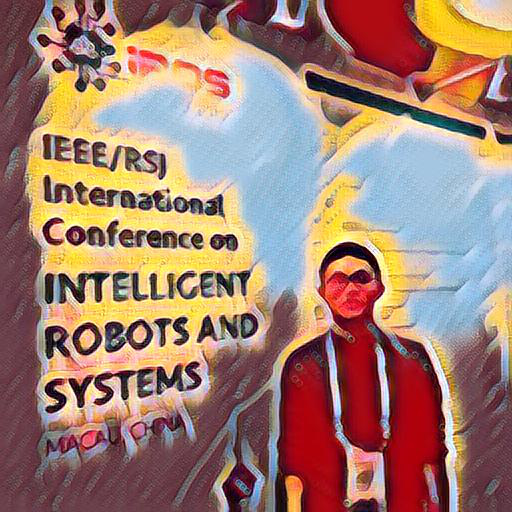

In [18]:
display(Image.open('output_personal.jpg'))

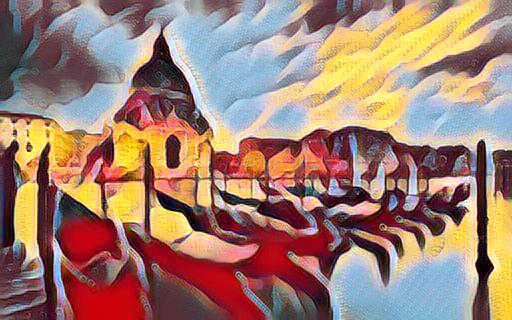

In [19]:
display(Image.open('output_demo.jpg'))

- **starry_night** Style

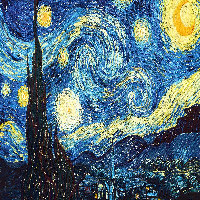

In [20]:
display(Image.open('./experiments/images/21styles/starry_night.jpg').resize((200, 200)))

In [21]:
style2 = tensor_load_rgbimage('./experiments/images/21styles/starry_night.jpg', size=512).unsqueeze(0)    
style2 = preprocess_batch(style2)
style_v2         = Variable(style2)
personal_image  = Variable(preprocess_batch(personal_image))
style_model.setTarget(style_v2)
output_personal2 = style_model(personal_image)
tensor_save_bgrimage(output_personal2.data[0], 'output_personal2.jpg', False)

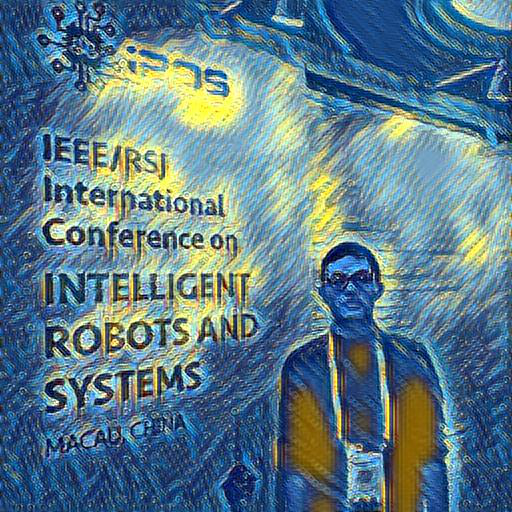

In [22]:
display(Image.open('output_personal2.jpg'))

- **pencil** Style

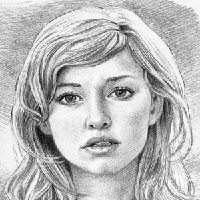

In [26]:
display(Image.open('./experiments/images/21styles/pencil.jpg').resize((200, 200)))

In [28]:
style3 = tensor_load_rgbimage('./experiments/images/21styles/pencil.jpg', size=512).unsqueeze(0)    
style3 = preprocess_batch(style3)
style_v3         = Variable(style3)
personal_image  = Variable(preprocess_batch(personal_image))
style_model.setTarget(style_v3)
output_personal3 = style_model(personal_image)
tensor_save_bgrimage(output_personal3.data[0], 'output_personal_pencil.jpg', False)

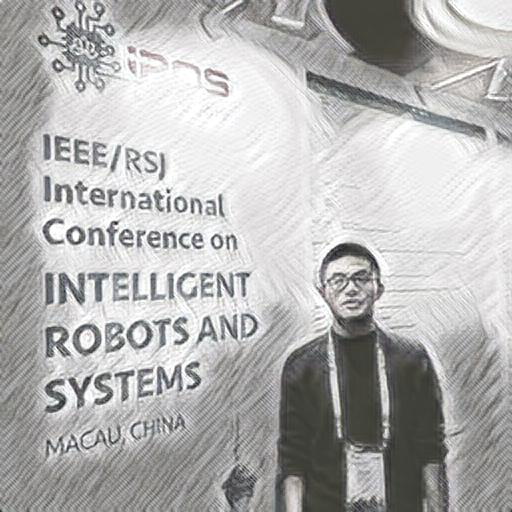

In [29]:
display(Image.open('output_personal_pencil.jpg'))